In [1]:
# -*- coding: utf-8 -*- 
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the N_BaIoT dataset. 
# implemented Max Voting tech. 

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.svm import SVC
import time
import numpy as np


In [2]:

df = pd.read_csv('/home/ibibers@ads.iu.edu/IOT_Datasets/device7.csv')


# Drop duplicates
df = df.drop_duplicates(keep='first')

# Drop columns that have just one unique value
one_value = df.columns[df.nunique() == 1]
df = df.drop(columns = one_value, axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115936 entries, 0 to 119999
Columns: 116 entries, MI_dir_L5_weight to label
dtypes: float64(115), int64(1)
memory usage: 103.5 MB


In [3]:


# Extract subsample of data
print (" Extract subsample of data: ")
print(df['label'].value_counts())

 Extract subsample of data: 
label
4    20000
3    20000
6    20000
1    19623
5    18157
2    18156
Name: count, dtype: int64


In [4]:
dropped_df = ['label']
X = df.drop(dropped_df, axis=1)
y = df['label']


In [5]:
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define individual models
model1 = KNeighborsClassifier()
model2 = DecisionTreeClassifier()  
model3 = LogisticRegression(solver='lbfgs', multi_class='multinomial')  
model4 = RandomForestClassifier(n_estimators=100, random_state=42)

# Combine models using VotingClassifier
ensemble_model = VotingClassifier(estimators=[('knn', model1), ('dst', model2), ('lr', model3) , ('rf' , model4)], voting='hard')

start_train_time = time.time()
# Train the ensemble model
ensemble_model.fit(X_train, y_train)
train_time = time.time() - start_train_time


start_pred_time = time.time()    
# Make predictions on new data (X_test)
y_pred = ensemble_model.predict(X_test)
pred_time = time.time() - start_pred_time

total_time = time.time() - start_time

/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
print("Time taken for training:{:f} seconds".format(train_time))
print("Time taken for prediction: {:f} seconds".format(pred_time))
print("Total time taken:{:f} seconds".format(total_time))

Time taken for training:29.316977 seconds
Time taken for prediction: 4.577403 seconds
Total time taken:34.003065 seconds


In [7]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:" ,accuracy)

# Without RF Accuracy: 0.6946977894574122

Accuracy: 0.9956585492079009


In [8]:
#  Classificaiton Report 
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           1       0.98      1.00      0.99      5892
           2       1.00      1.00      1.00      5481
           3       1.00      1.00      1.00      6147
           4       1.00      0.98      0.99      5966
           5       1.00      1.00      1.00      5433
           6       1.00      1.00      1.00      5862

    accuracy                           1.00     34781
   macro avg       1.00      1.00      1.00     34781
weighted avg       1.00      1.00      1.00     34781



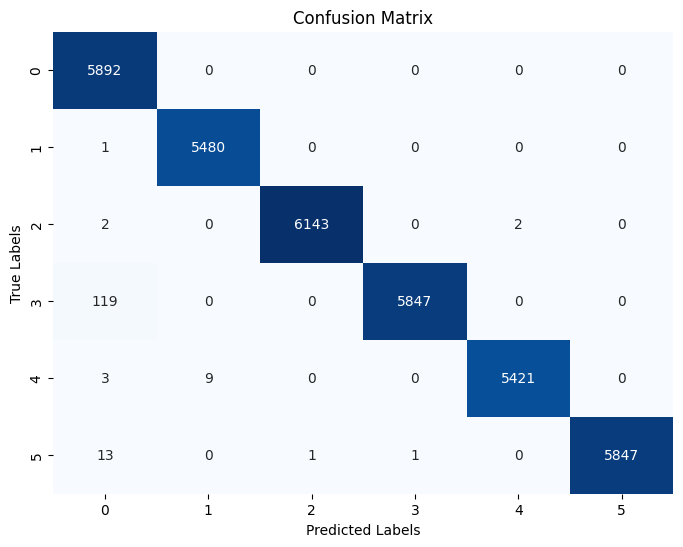

In [9]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [10]:

# Fit models individually before computing feature importance
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)
# Calculate feature importance indirectly using permutation importance for KNeighborsClassifier and SVC
feature_importance = {}

# Permutation importance for KNeighborsClassifier
# Note: This is computationally expensive, especially for large datasets
from sklearn.inspection import permutation_importance
knn_perm_importance = permutation_importance(model1, X_test, y_test, n_repeats=30, random_state=42)
for i, column in enumerate(X.columns):
    feature_importance[column] = knn_perm_importance.importances_mean[i]

# Permutation importance for SVC
# Note: This is also computationally expensive
svc_perm_importance = permutation_importance(model2, X_test, y_test, n_repeats=30, random_state=42)
for i, column in enumerate(X.columns):
    feature_importance[column] += svc_perm_importance.importances_mean[i]

# Coefficients for LogisticRegression
log_reg_coef = np.abs(model3.coef_[0])
for i, column in enumerate(X.columns):
    feature_importance[column] += log_reg_coef[i]

# Normalize feature importance
total_importance = sum(feature_importance.values())
for key in feature_importance:
    feature_importance[key] /= total_importance

# Sort feature importance
sorted_importance = dict(sorted(feature_importance.items(), key=lambda x: x[1], reverse=True))

# Plot the feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x=list(sorted_importance.values()), y=list(sorted_importance.keys()), palette='cubehelix')
plt.xlabel('Importance Value')
plt.ylabel('Feature Name')
plt.title('Feature Importance in Voting Classifier')
plt.show()

/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
